In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

from torchts.nn.loss import quantile_loss
from torchts.nn.model import TimeSeriesModel

# Generate data

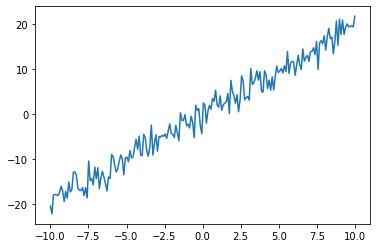

In [2]:
# generate linear time series data with some noise
n = 200
x_max = 10
slope = 2
scale = 2

x = torch.from_numpy(np.linspace(-x_max, x_max, n).reshape(-1, 1).astype(np.float32))
y = slope * x + np.random.normal(0, scale, n).reshape(-1, 1).astype(np.float32)

plt.plot(x, y)
plt.show()

# Define model that predicts quantiles

In [3]:
class QuantileLSTM(TimeSeriesModel):
    def __init__(
        self, input_size, output_size, hidden_size, optimizer, quantile=0.5, **kwargs
    ):
        super().__init__(
            optimizer,
            criterion=quantile_loss,
            criterion_args={"quantile": quantile},
            **kwargs
        )
        n_quantiles = 1 if isinstance(quantile, float) else len(quantile)
        self.lstm = nn.ModuleList(
            [nn.LSTMCell(input_size, hidden_size) for _ in range(output_size)]
        )
        self.linear = nn.ModuleList(
            [nn.Linear(hidden_size, n_quantiles) for _ in range(output_size)]
        )

    def forward(self, x, y=None, batches_seen=None):
        hidden, _ = zip(*[m(x) for m in self.lstm])
        out = [m(h) for m, h in zip(self.linear, hidden)]
        return torch.hstack(out)

In [4]:
input_size = 1
output_size = 1
hidden_size = 16
quantile = 0.5
optimizer = optim.Adam
optimizer_args = {"lr": 0.005}
max_epochs = 100
batch_size = 10

model = QuantileLSTM(
    input_size,
    output_size,
    hidden_size,
    optimizer,
    quantile=quantile,
    optimizer_args=optimizer_args,
)

# Train model to predict a single quantile

In [5]:
# train model
model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)

# inference
y_preds = model.predict(x)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/klane/.repos/github.com/Rose-STL-Lab/torchTS/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name   | Type       | Params
--------------------------------------
0 | lstm   | ModuleList | 1.2 K 
1 | linear | ModuleList | 17    
--------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
/Users/klane/.repos/github.com/Rose-STL-Lab/torchTS/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider

Epoch 99: 100%|██████████| 20/20 [00:00<00:00, 229.79it/s, loss=0.756, v_num=229, train_loss_step=0.662, train_loss_epoch=0.756]


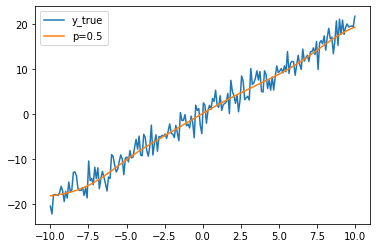

In [6]:
plt.plot(x, y, label="y_true")
plt.plot(x, y_preds, label=f"p={quantile}")
plt.legend()
plt.show()

# Train model to predict multiple quantiles

In [7]:
quantile = [0.025, 0.5, 0.975]

model = QuantileLSTM(
    input_size,
    output_size,
    hidden_size,
    optimizer,
    quantile=quantile,
    optimizer_args=optimizer_args,
)

In [8]:
# train model
model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)

# inference
y_preds = model.predict(x)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/klane/.repos/github.com/Rose-STL-Lab/torchTS/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name   | Type       | Params
--------------------------------------
0 | lstm   | ModuleList | 1.2 K 
1 | linear | ModuleList | 51    
--------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
/Users/klane/.repos/github.com/Rose-STL-Lab/torchTS/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider

Epoch 99: 100%|██████████| 20/20 [00:00<00:00, 226.46it/s, loss=0.964, v_num=230, train_loss_step=0.971, train_loss_epoch=0.964]


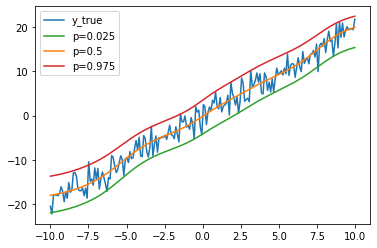

In [9]:
n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x, y, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x, y_preds[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

plt.legend()
plt.show()

# Add second response variable

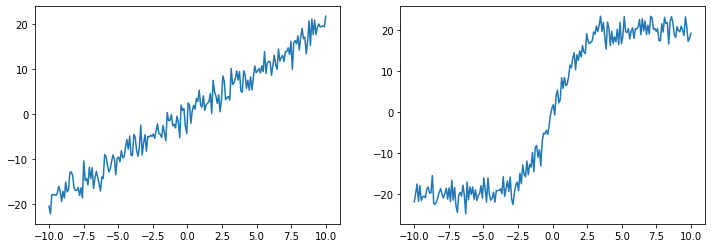

In [10]:
y_max = slope * x_max
y2 = 2 * y_max / (1 + np.exp(-x)) - y_max
y2 += np.random.normal(0, scale, n).reshape(-1, 1).astype(np.float32)
y = torch.hstack([y, y2])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x, y[:, 0])
plt.subplot(1, 2, 2)
plt.plot(x, y[:, 1])
plt.show()

# Train model to predict quantiles for two response variables

In [11]:
output_size = 2

model = QuantileLSTM(
    input_size,
    output_size,
    hidden_size,
    optimizer,
    quantile=quantile,
    optimizer_args=optimizer_args,
)

In [12]:
# train model
model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)

# inference
y_preds = model.predict(x)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/klane/.repos/github.com/Rose-STL-Lab/torchTS/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name   | Type       | Params
--------------------------------------
0 | lstm   | ModuleList | 2.4 K 
1 | linear | ModuleList | 102   
--------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
/Users/klane/.repos/github.com/Rose-STL-Lab/torchTS/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider

Epoch 99: 100%|██████████| 20/20 [00:00<00:00, 202.01it/s, loss=1.93, v_num=231, train_loss_step=2.320, train_loss_epoch=1.930]


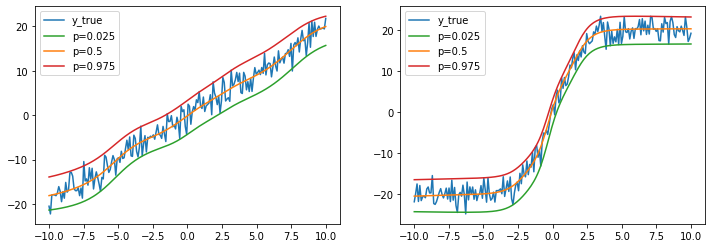

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x, y[:, 0], label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x, y_preds[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, y[:, 1], label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x, y_preds[:, i + n_quantiles], c=cycle_colors[c], label=f"p={quantile[i]}")

plt.legend()

plt.show()